# Exploratory Data Analyis - MVP 
## Phillip Richardson

#### Initial Findings
Rush hour ridership is increasing week over week (with the exception of weeks with snowstorm or Monday holiday) as seen below. Even with the snowstorm and holidays the trend is increasing.


Total Station Traffic.png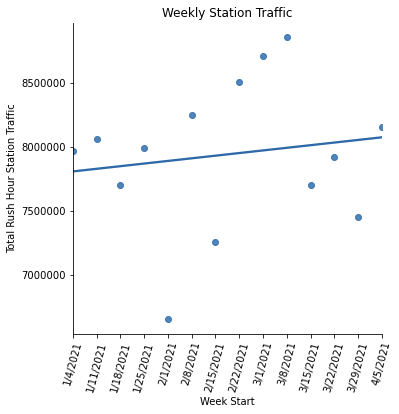

I was able to identify  high and low traffic stations during the morning and evening rush hour time slots using weighted ranking of total traffic and change in traffic over time. The Top/Bottom 3 to 5 stations (just a matter of slicing that needs to be fixed) for the highest overall traffic by their rush hour window can be seen below (legend to be added)

Top 5 Morning Rush.png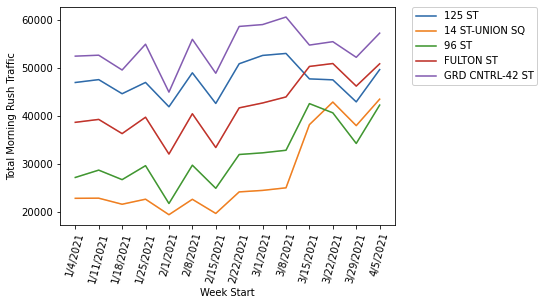

I also have assigned the stations into deciles (per rush hour window) to allow for quickly identifying where staffing can be poached from (top 10% borrowing from bottom 10%)

In [338]:
# import urllib.request

# url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
# week_nums = [210109, 210116, 210123, 210130, 210206, 210213, 210220, 210227, 210306, 210313, 210320,
# 210327, 210403, 210410, 210417]

# for week_num in week_nums:
#     urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
#                                f"data/turnstile_{week_num}.txt")

In [447]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline


#### SQL Query pulling data from personal DB

In [340]:
engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('with mta as(select *, row_number() over (PARTITION by CA, UNIT,  STATION,  SCP, date, time order by CA, UNIT,  STATION,  SCP, date, time) as dupes from mta_data) select *, case when (time between "08:00:00" and "11:00:00" ) then "Morning rush" when (time between "18:00:00" and "22:00:00" ) then "Evening rush" else "" end as rush_hour, LAG ( entries, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time)  as entered, LAG ( exits, 1, 0 ) OVER ( partition by CA, UNIT,  STATION,  SCP ORDER BY date, time) as exited from mta where dupes = 1;', engine)

#### Creating DOW column and week_num column

In [341]:
# Converting the text date into an actual date value
all_data['DOW'] = pd.to_datetime(all_data['DATE'])

# Converting the new date value into a Day of Week format
all_data['DOW1'] = all_data['DOW'].dt.strftime('%a')
all_data['week_num'] = all_data['DOW'].dt.strftime('%V').astype(int)


#### Creating the numeric fields to measure traffic by, and filtering data down to desired set

In [486]:
# Isolating weekdays and rush hour time window

all_data['Agg_enters'] = all_data['ENTRIES'] - all_data['entered']
all_data['Agg_exits'] = all_data['EXITS'] - all_data['exited']
all_data['traffic'] = all_data['Agg_enters'] + all_data['Agg_exits']

neg = (all_data['traffic'] < 0)

all_data.loc[neg, 'traffic'] = all_data.loc[neg, 'traffic'] * -1


#Avoid magic number (40,000), ignore week 53 (very beginning of JAN)

mask = (all_data['entered'] != 0) & (all_data['DOW1'] != 'Sat') &  (all_data['DOW1'] != 'Sun') & (all_data['rush_hour'] != "") & (all_data['traffic'] < 40000) & (all_data['week_num'] < 15)



## Aproach to Outliers

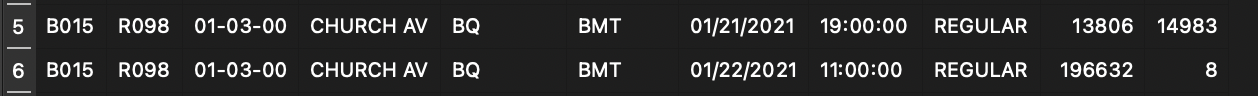

One of the reasons for outliers (based on 'Agg_enters' and 'Agg_exits' columns) is missing and faulty raw data. We are missing 3 records for the attached screenshot, and the 'Entries' and 'Exits' values don't make sense in the way that the cumulative numbers either jump drastically or fall drastically. 

I believe the best course of action, because this stems from the raw data, is to drop these rows with _extreme_ values (>40,000k agg_enter+exits). After checking ~100 rows of the data (random groups of 10) for validity in the 'Agg_enters' and 'Agg_exits' columns (manually comparing prior hour slot records, and doing the arithmetic by hand), it seems that the data not considered outliers are accurately calculated.  

#### Creating Analysis level (daily and weekly) dataframes, then creating weekly means for both total traffic and change in traffic

In [394]:
# Not sure I really need to create 2 DFs here

station_daily = all_data[mask].groupby(['STATION', 'DOW', 'rush_hour', 'week_num', 'DOW1']).traffic.sum().reset_index().copy()
station_weekly = station_daily.groupby(['STATION', 'week_num', 'rush_hour']).traffic.sum().reset_index().copy()

In [395]:
station_weekly['avg_traffic'] = station_weekly.groupby(['STATION','rush_hour']).traffic.transform(lambda x: x.mean())
station_weekly['traffic_change'] = station_weekly.groupby(['STATION', 'rush_hour']).traffic.diff()
station_weekly['avg_change'] =  station_weekly.groupby(['STATION','rush_hour']).traffic_change.transform(lambda x: x.mean())

In [396]:
station_total = station_weekly.groupby(['STATION', 'rush_hour']).agg({'traffic': 'sum',
                                                                      'avg_traffic': 'mean',
                                                                      'avg_change' : 'mean'   
}).reset_index().copy()

#### Ranking the total traffic and change in traffic fields, then creating a weighted rank of those 2 ranks. Then re-ranking on weighted rank

In [397]:
station_total['change_ranked'] =  station_total.groupby(['rush_hour']).avg_change.transform(lambda x: x.rank(ascending = False))
station_total['traffic_ranked'] =  station_total.groupby(['rush_hour']).avg_traffic.transform(lambda x: x.rank(ascending = False))


In [398]:
station_total['weighted_rank'] = (station_total['traffic_ranked'] * .75) + (station_total['change_ranked'] * .25)
station_total['final_rank'] =  station_total.groupby(['rush_hour']).weighted_rank.transform(lambda x: x.rank(ascending = True, method = 'first'))

#### Deciling the weighted final ranks

In [526]:
decile_level = max(station_total.final_rank)/10
station_total['traffic_decile'] = np.ceil(station_total['final_rank']/decile_level)

station_total.to_csv("/Users/philliprichardson/Metis/Module 1/deciled stations.csv")

#### Creating plot DFs for Seaborn

In [404]:
weeks = (['1/4/2021', '1/11/2021', '1/18/2021', '1/25/2021', '2/1/2021', '2/8/2021', '2/15/2021', '2/22/2021',
         '3/1/2021', '3/8/2021', '3/15/2021', '3/22/2021', '3/29/2021', '4/5/2021'])

top_morning = station_total[station_total['rush_hour'] == 'Morning rush'].sort_values(by = 'final_rank').iloc[:5]

bot_morning = station_total[station_total['rush_hour'] == 'Morning rush'].sort_values(by = 'final_rank').iloc[-5:]

top_evening = station_total[station_total['rush_hour'] == 'Evening rush'].sort_values(by = 'final_rank').iloc[:5]

bot_evening = station_total[station_total['rush_hour'] == 'Evening rush'].sort_values(by = 'final_rank').iloc[-5:]





top_m_plot = station_weekly.merge(top_morning, on = ['STATION', 'rush_hour'])

bot_m_plot = station_weekly.merge(bot_morning, on = ['STATION', 'rush_hour'])

top_e_plot = station_weekly.merge(top_evening, on = ['STATION', 'rush_hour'])

bot_e_plot = station_weekly.merge(bot_evening, on = ['STATION', 'rush_hour'])



#### Creating overall rush hour traffic plot by week to evaluate the weekly ridership patterns

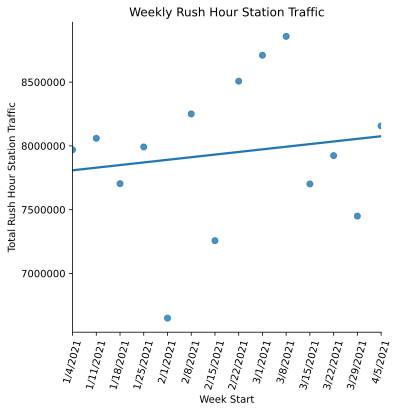

In [516]:
total_weekly = station_weekly.groupby(['week_num']).traffic.sum().reset_index()

sns.lmplot(x = 'week_num', y = 'traffic', data = total_weekly, ci = None)
plt.title('Weekly Rush Hour Station Traffic')
x_ticks = total_weekly['week_num'].unique()
plt.xlabel('Week Start')
plt.ylabel('Total Rush Hour Station Traffic')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(x_ticks, labels = weeks, rotation = 75);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Total Station Traffic.png",bbox_inches='tight')

#### Create Total Traffic plots for top & bottom 5 for Morning & Evening rush

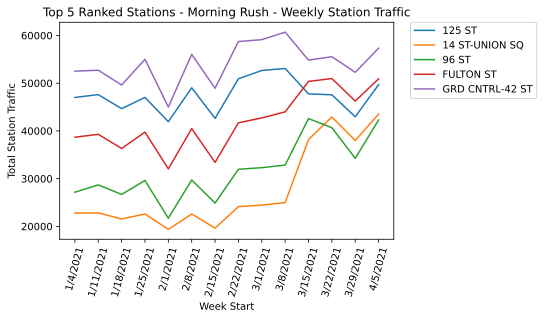

In [517]:
sns.lineplot(data = top_m_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_x')
plt.title('Top 5 Ranked Stations - Morning Rush - Weekly Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('Total Station Traffic')
x_ticks = top_m_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Top 5 Morning Rush.png",bbox_inches='tight')

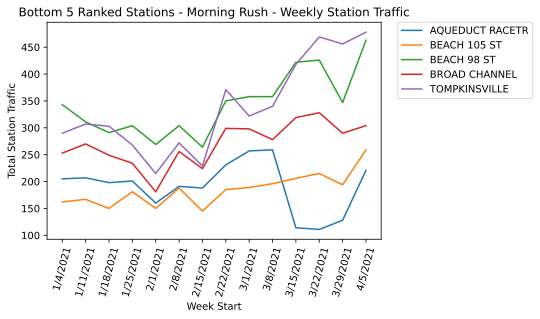

In [518]:
sns.lineplot(data = bot_m_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_x')
plt.xlabel('Week Start')
plt.ylabel('Total Station Traffic')
plt.title('Bottom 5 Ranked Stations - Morning Rush - Weekly Station Traffic')
x_ticks = bot_m_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Bot 5 Morning Rush.png",bbox_inches='tight')

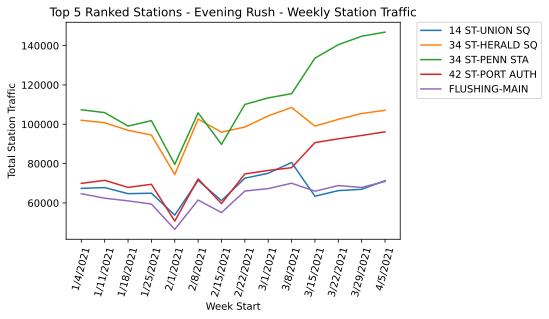

In [519]:
sns.lineplot(data = top_e_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_x')
plt.title('Top 5 Ranked Stations - Evening Rush - Weekly Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('Total Station Traffic')
x_ticks = top_e_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Top 5 Evening Rush.png",bbox_inches='tight')

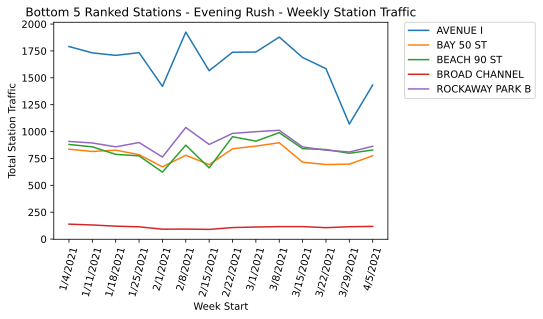

In [520]:
sns.lineplot(data = bot_e_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_x')
plt.title('Bottom 5 Ranked Stations - Evening Rush - Weekly Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('Total Station Traffic')
x_ticks = bot_e_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Bot 5 Evening Rush.png",bbox_inches='tight')

#### Create Change in Traffic plots for top & bottom 5 for Morning & Evening rush

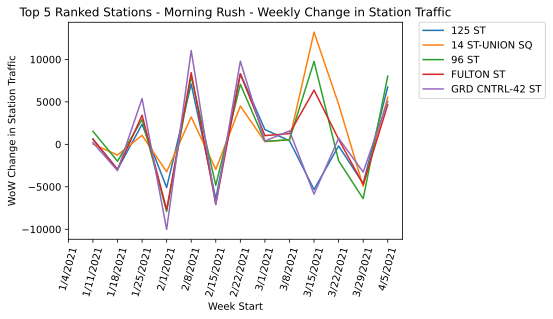

In [521]:
sns.lineplot(data = top_m_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_change')
plt.title('Top 5 Ranked Stations - Morning Rush - Weekly Change in Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('WoW Change in Station Traffic')
x_ticks = top_m_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Top 5 Change Morning Rush.png",bbox_inches='tight')

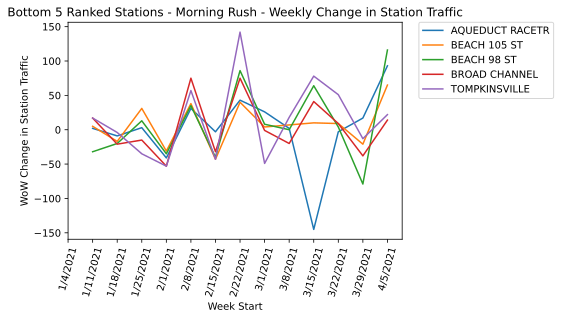

In [522]:
sns.lineplot(data = bot_m_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_change')
plt.title('Bottom 5 Ranked Stations - Morning Rush - Weekly Change in Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('WoW Change in Station Traffic')
x_ticks = bot_m_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Bot 5 Change Morning Rush.png",bbox_inches='tight')

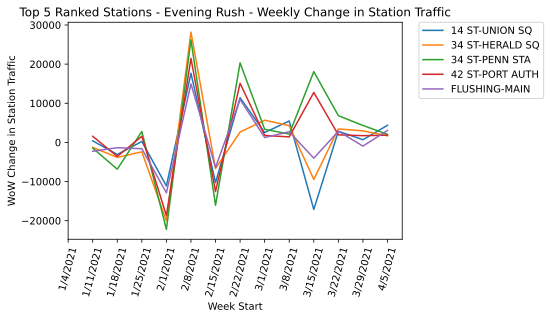

In [525]:
sns.lineplot(data = top_e_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_change')
plt.title('Top 5 Ranked Stations - Evening Rush - Weekly Change in Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('WoW Change in Station Traffic')
x_ticks = top_e_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Top 5 Change Evening Rush.png",bbox_inches='tight')

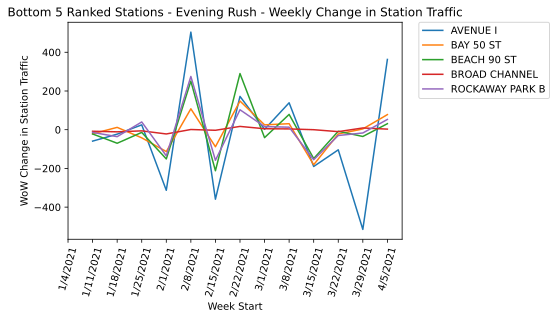

In [524]:
sns.lineplot(data = bot_e_plot, hue = 'STATION',  x = 'week_num', y = 'traffic_change')
plt.title('Bottom 5 Ranked Stations - Evening Rush - Weekly Change in Station Traffic')
plt.xlabel('Week Start')
plt.ylabel('WoW Change in Station Traffic')
x_ticks = bot_e_plot['week_num'].unique()
plt.xticks(x_ticks, labels = weeks, rotation = 75)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

plt.savefig("/Users/philliprichardson/Metis/Module 1/Bot 5 Change Evening Rush.png",bbox_inches='tight')